In [1]:
import sys
sys.path.append(sys.path[0] + '/deepkexpfam')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import save_object, load_object
from utils import make_grid_data, plot_object2D, plot_outrange, flow_density, object_density, find_outrange
from flows import Flow

from Datasets import Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring

%matplotlib inline

In [3]:
# Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring
save_path = './saved_flows_affine_llimit_data/'

d = 1
D = 2
layers = 20
dropout_rate = 0.1

sample_size = 500
batch_size = 100
epochs = 200
lr = 0.01
weight_decay = 0.01

names = ['Funnel', 'Banana', 'Ring', 'Uniform', 'Cosine', 'Grid', 'Multiring']
objs = [Funnel(), Banana(), Ring(), Uniform(), Cosine(), Grid(), Multiring()]

iters = 100
n_x, n_y = 500, 500
x_interval, y_interval = np.linspace(-7, 7, n_x), np.linspace(-7, 7, n_y)
grid_x, grid_y, X = make_grid_data(x_interval, y_interval)

In [4]:
# Train flows
# flows = []
# for obj in objs:
#     while True:
#         try:
#             flow = Flow(d, D, layers, dropout_rate)
#             flow.train(obj, sample_size, batch_size, epochs, lr, weight_decay, show_progress=True)
#             flows.append(flow)
#         except ValueError:
#             print('Value error')
#         except RuntimeError:
#             print('Runtime error')
#         else:
#             break

# Compute and save/load densities for flows
# pX_dict = {}
# for i in range(len(flows)):
#     name = names[i]
#     flow = flows[i]
    
#     pX_iters = np.zeros((iters, n_x, n_y))
#     for j in range(iters):
#         pX_iters[j, :, :] = flow_density(flow, X).reshape(n_x, n_y)
    
#     print(name)
#     pX_dict[name] = pX_iters

# save_object(pX_dict, save_path + 'pX_dict_dropout')

pX_dict = load_object(save_path + 'pX_dict_dropout')

In [5]:
# Precompute object densities
pX_objs = []
for i in range(len(names)):
    obj = objs[i]
    name = names[i]
    
    pX_obj = object_density(obj, X).reshape(n_x, n_y)
    pX_objs.append(pX_obj)
    
    print(name)

Funnel
Banana
Ring
Uniform
Cosine
Grid
Multiring


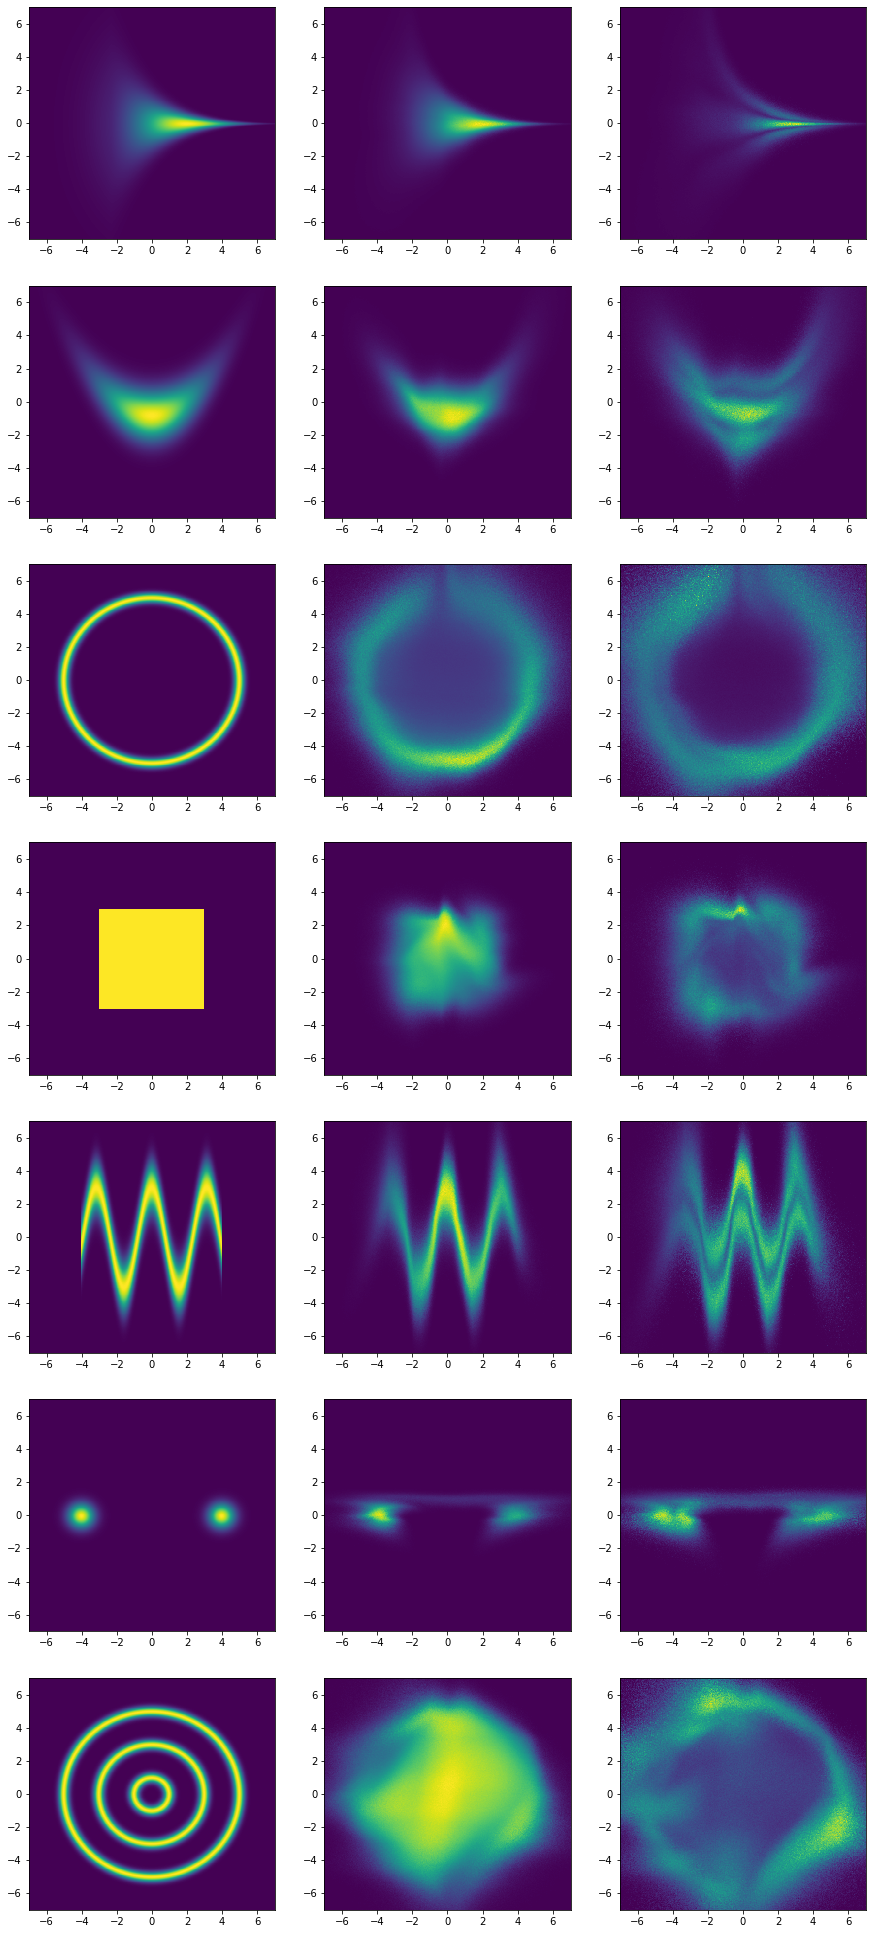

In [6]:
# plot mean and standard deviation
plt.figure(figsize=(15,35))
for i in range(len(names)):
    pX_obj = pX_objs[i]
    name = names[i]
    
    pX_iters = pX_dict[name]
    pX_mean = pX_iters.mean(axis=0)
    pX_std = pX_iters.std(axis=0)
    
    # clip large value
    #max_val = 0.1 * pX_std.max()
    #idx = pX_std > max_val
    #pX_std[idx] = max_val
    
    plt.subplot(7, 3, 3*i+1)
    plt.pcolormesh(grid_x, grid_y, pX_obj, shading='auto')
    plt.subplot(7, 3, 3*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_mean, shading='auto')
    plt.subplot(7, 3, 3*i+3)
    plt.pcolormesh(grid_x, grid_y, pX_std, shading='auto')

overall std = 0.0018


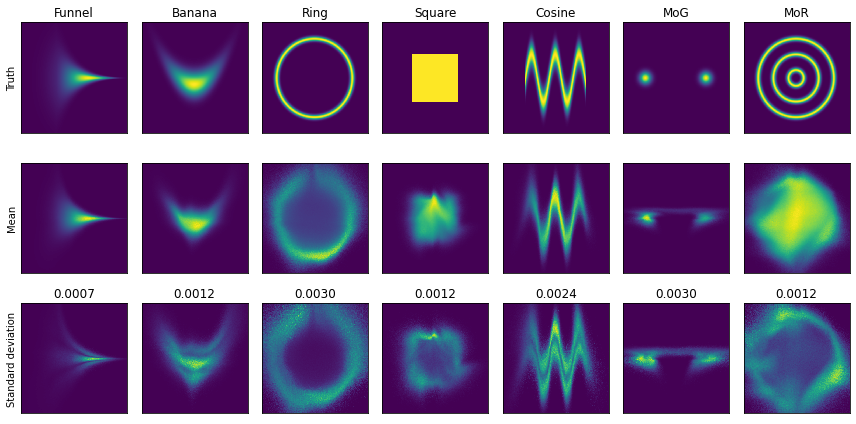

In [7]:
# plot mean and standard deviation
plot_names = ['Funnel', 'Banana', 'Ring', 'Square', 'Cosine', 'MoG', 'MoR']

plt.figure(figsize=(12, 6))
for i in range(len(names)):
    pX_obj = pX_objs[i]
    name = names[i]
    plot_name = plot_names[i]
    
    pX_iters = pX_dict[name]
    pX_mean = pX_iters.mean(axis=0)
    pX_std = pX_iters.std(axis=0)
    
    # clip large value
    #max_val = 0.1 * pX_std.max()
    #idx = pX_std > max_val
    #pX_std[idx] = max_val
    
    plt.subplot(3, 7, i+1)
    plt.pcolormesh(grid_x, grid_y, pX_obj, shading='auto')
    plt.title(plot_name)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3, 7, i+8)
    plt.pcolormesh(grid_x, grid_y, pX_mean, shading='auto')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Mean')
    
    plt.subplot(3, 7, i+15)
    plt.title('%.4f' % pX_std.mean())
    plt.pcolormesh(grid_x, grid_y, pX_std, shading='auto')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Standard deviation')

plt.tight_layout()

overall_std = []
for i in range(len(names)):
    name = names[i]
    pX_iters = pX_dict[name]
    std = pX_iters.std(axis=0).mean()
    overall_std.append(std)
print('overall std = %.4f' % np.mean(overall_std))

In [8]:
# Precompute outranges for all objects
conf_intervals = [10, 50, 90]

pX_outranges_dict = {}
for i in range(len(names)):
    name = names[i]
    
    pX_obj = pX_objs[i]
    pX_iters = pX_dict[name]
    
    pX_outranges = []
    for conf_interval in conf_intervals:
        pX_outrange = find_outrange(pX_obj, pX_iters, conf_interval)
        pX_outranges.append(pX_outrange)
    
    pX_outranges_dict[name] = pX_outranges
    
    print(name)

Funnel
Banana
Ring
Uniform
Cosine
Grid
Multiring


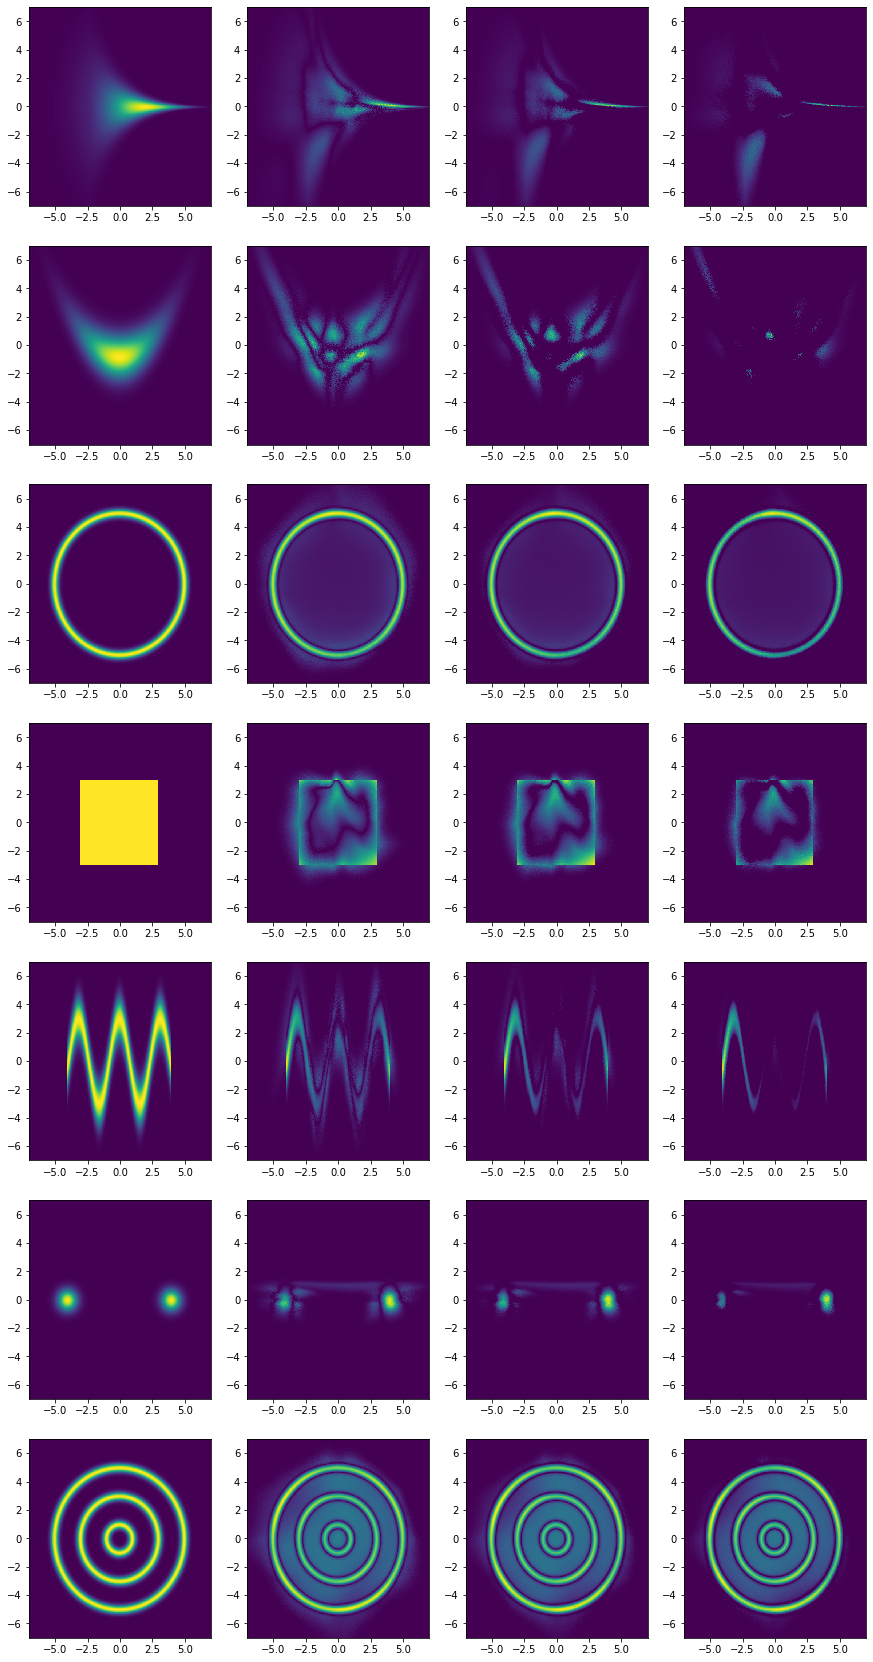

In [9]:
# Plot confidence interval
plt.figure(figsize=(15,30))
for i in range(len(names)):
    name = names[i]
    
    obj = objs[i]
    pX_obj = pX_objs[i]
    
    pX_iters = pX_dict[name]
    pX_outranges = pX_outranges_dict[name]
    
    plt.subplot(7, 4, 4*i+1)
    plt.pcolormesh(grid_x, grid_y, pX_obj, shading='auto')
    
    plt.subplot(7, 4, 4*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_outranges[0], shading='auto')
    plt.subplot(7, 4, 4*i+3)
    plt.pcolormesh(grid_x, grid_y, pX_outranges[1], shading='auto')
    plt.subplot(7, 4, 4*i+4)
    plt.pcolormesh(grid_x, grid_y, pX_outranges[2], shading='auto')

In [10]:
table = {}
for i in range(len(names)):
    name = names[i]
    pX_outranges = pX_outranges_dict[name]
    means = []
    for j in range(len(conf_intervals)):
        means.append(pX_outranges[j].mean())
    table[name] = means


print('\t\t', end='')
for conf_interval in conf_intervals:
    print(str(conf_interval) + '%', end='\t')

print('')

for name in names:
    print(name, end='    ')
    for mean in table[name]:
        print('\t%2.2f' % (mean*1e6), end='')
    
    print('')
    
print('\nAverage deviation from confidence interval * 1e6')

		10%	50%	90%	
Funnel    	572.38	315.07	112.45
Banana    	564.06	194.38	14.21
Ring    	5809.11	4761.81	3577.51
Uniform    	1824.70	1321.34	714.97
Cosine    	1660.19	938.39	498.86
Grid    	2783.12	1719.44	793.11
Multiring    	5526.68	5012.86	4371.91

Average deviation from confidence interval * 1e6


In [11]:
table = {}
for i in range(len(names)):
    name = names[i]
    pX_outranges = pX_outranges_dict[name]
    means = []
    for j in range(len(conf_intervals)):
        means.append(np.mean(pX_outranges[j] == 0.))
    table[name] = means


print('\t\t', end='')
for conf_interval in conf_intervals:
    print(str(conf_interval) + '%', end='\t')

print('')

for name in names:
    print(name, end='    ')
    for mean in table[name]:
        print('\t%2.2f' % (mean), end='')
    
    print('')

print('')
    
print('Overall', end='    ')

for i in range(len(conf_intervals)):
    column = []
    for name in table:
        column.append(table[name][i])
    print('\t%2.2f' % (np.mean(column)), end='')

print('')
    
print('\npercentage of pixels inside confidence interval')

		10%	50%	90%	
Funnel    	0.17	0.35	0.67
Banana    	0.07	0.37	0.75
Ring    	0.04	0.22	0.49
Uniform    	0.21	0.33	0.51
Cosine    	0.11	0.29	0.53
Grid    	0.03	0.15	0.42
Multiring    	0.03	0.17	0.36

Overall    	0.09	0.27	0.53

percentage of pixels inside confidence interval
